In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
calls = pd.read_csv('../data/raw/megaline_calls.csv')
internet = pd.read_csv('../data/raw/megaline_internet.csv')
messages = pd.read_csv('../data/raw/megaline_messages.csv')
plans = pd.read_csv('../data/raw/megaline_plans.csv')
users = pd.read_csv('../data/raw/megaline_users.csv')

Modificar tipos de datos

In [67]:
# Convertir fechas a datetime
calls["call_date"] = pd.to_datetime(calls["call_date"])
internet["session_date"] = pd.to_datetime(internet["session_date"])
messages["message_date"] = pd.to_datetime(messages["message_date"])
users["reg_date"] = pd.to_datetime(users["reg_date"])
users["churn_date"] = pd.to_datetime(users["churn_date"])

In [68]:
type(calls["call_date"][0])

pandas._libs.tslibs.timestamps.Timestamp

# Manejo de Outliers

Se descartan los outliers identificador en el EDA

In [69]:
# Función para eliminar outliers usando IQR
def remove_outliers(df, column, high,  low = 0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    print(f"Lower: {lower_bound}")
    upper_bound = Q3 + 1.5 * IQR
    print(f"Upper: {upper_bound}")

    final = df[(df[column] >= lower_bound) & (df[column] <= high)]
    num_lower = df[df[column] < lower_bound]
    num_upper = df[df[column] > high]
    print(f"Num lower: {len(num_lower)}")
    print(f"Num upeer: {len(num_upper)}")
    return final

# Eliminar outliers en la duración de llamadas
print("Call duration --------")
calls_clean = remove_outliers(calls, "duration", high= 30)

# Eliminar outliers en el consumo de datos
print("Internet mb used --------")
internet_clean = remove_outliers(internet, "mb_used", high= 1500)

# Contar mensajes por usuario y eliminar outliers
print("Messages per user --------")
messages_per_user = messages["user_id"].value_counts().reset_index()
messages_per_user.columns = ["user_id", "message_count"]
messages_per_user_clean = remove_outliers(messages_per_user, "message_count", high= 700)

# Filtrar solo los usuarios que pasaron el filtro de outliers
messages_clean = messages[messages["user_id"].isin(messages_per_user_clean["user_id"])]

Call duration --------
Lower: -12.809999999999999
Upper: 24.79
Num lower: 0
Num upeer: 44
Internet mb used --------
Lower: -491.7149999999999
Upper: 1182.405
Num lower: 0
Num upeer: 18
Messages per user --------
Lower: -238.125
Upper: 556.875
Num lower: 0
Num upeer: 7


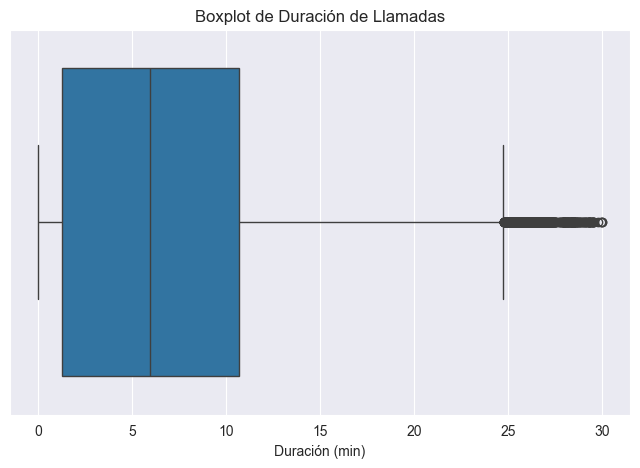

In [70]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=calls_clean["duration"])
plt.title("Boxplot de Duración de Llamadas")
plt.xlabel("Duración (min)")
plt.show()

Text(0.5, 0, 'MB Usados')

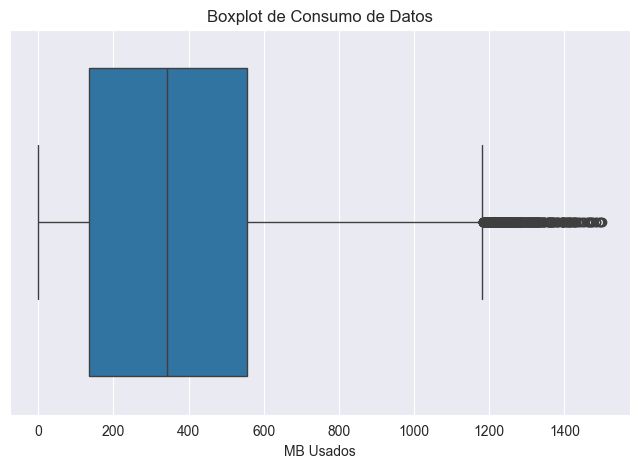

In [71]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=internet_clean["mb_used"])
plt.title("Boxplot de Consumo de Datos")
plt.xlabel("MB Usados")


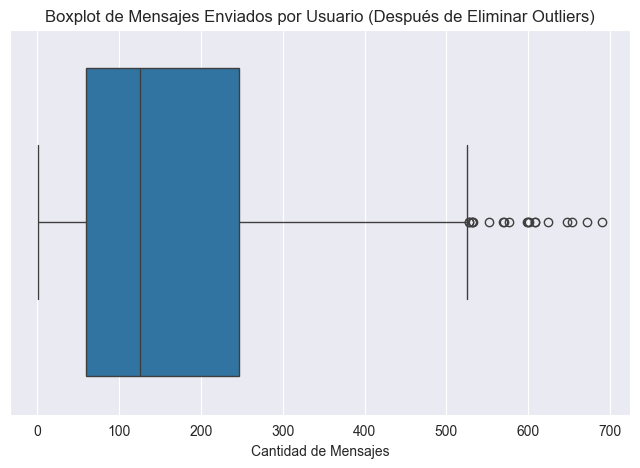

In [72]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=messages_per_user_clean["message_count"])
plt.title("Boxplot de Mensajes Enviados por Usuario (Después de Eliminar Outliers)")
plt.xlabel("Cantidad de Mensajes")
plt.show()

In [73]:
calls_clean

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37


In [74]:
internet_clean

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06
104821,1499_216,1499,2018-12-30,304.72
104822,1499_217,1499,2018-09-22,292.75
104823,1499_218,1499,2018-12-07,0.00


In [75]:
messages_clean

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24


Exportar datos clean

In [76]:
messages_clean.to_csv("../data/clean/messages_clean.csv", index=False)
internet_clean.to_csv("../data/clean/internet_clean.csv", index=False)
calls_clean.to_csv("../data/clean/calls_clean.csv", index=False)
plans.to_csv("../data/clean/plans_clean.csv", index=False)
users.to_csv("../data/clean/users_clean.csv", index=False)


# Modelado Tabla de hechos


Primer intento de hacer un fact table = fail

In [77]:
'''calls = calls_clean[["user_id", "duration"]]
internet = internet_clean[["user_id", "mb_used"]]
messages = messages_clean["user_id"]
users = users[["user_id", "plan"]]


# Unir los datos usando outer joins
fact_table = users.merge(calls, on="user_id", how="outer")
fact_table = fact_table.merge(internet, on="user_id", how="outer")
fact_table = fact_table.merge(messages, on="user_id", how="outer")
fact_table = fact_table.merge(plans, left_on="plan", right_on="plan_name", how="left")



# Llenar valores nulos en columnas numéricas con 0
numeric_cols = ["duration", "mb_used", "user_id"]
for col in numeric_cols:
    if col in fact_table.columns:
        fact_table[col] = fact_table[col].fillna(0)

fact_table'''

'calls = calls_clean[["user_id", "duration"]]\ninternet = internet_clean[["user_id", "mb_used"]]\nmessages = messages_clean["user_id"]\nusers = users[["user_id", "plan"]]\n\n\n# Unir los datos usando outer joins\nfact_table = users.merge(calls, on="user_id", how="outer")\nfact_table = fact_table.merge(internet, on="user_id", how="outer")\nfact_table = fact_table.merge(messages, on="user_id", how="outer")\nfact_table = fact_table.merge(plans, left_on="plan", right_on="plan_name", how="left")\n\n\n\n# Llenar valores nulos en columnas numéricas con 0\nnumeric_cols = ["duration", "mb_used", "user_id"]\nfor col in numeric_cols:\n    if col in fact_table.columns:\n        fact_table[col] = fact_table[col].fillna(0)\n\nfact_table'

Segundo intento

In [78]:
# Extraer año y mes en una nueva columna
calls["month_year"] = calls["call_date"].dt.to_period("M")
internet["month_year"] = internet["session_date"].dt.to_period("M")
messages["month_year"] = messages["message_date"].dt.to_period("M")

# Agregar el consumo total por usuario y mes
calls_agg = calls.groupby(["user_id", "month_year"]).agg({"duration": "sum"}).reset_index()
internet_agg = internet.groupby(["user_id", "month_year"]).agg({"mb_used": "sum"}).reset_index()
messages_agg = messages.groupby(["user_id", "month_year"]).agg({"user_id": "count"}).rename(columns={"user_id": "message_count"}).reset_index()

# Crear base con todos los usuarios y los meses disponibles
users["key"] = 1
months = pd.DataFrame(pd.date_range(start=calls["call_date"].min(), end=calls["call_date"].max(), freq='MS').to_period("M"), columns=["month_year"])
months["key"] = 1
user_months = users.merge(months, on="key").drop(columns=["key"])

# Unir primero los datos agregados de consumo usando LEFT JOIN
fact_table = user_months.merge(calls_agg, on=["user_id", "month_year"], how="left")
fact_table = fact_table.merge(internet_agg, on=["user_id", "month_year"], how="left")
fact_table = fact_table.merge(messages_agg, on=["user_id", "month_year"], how="left")

# Unir con la tabla de planes
fact_table = fact_table.merge(plans, left_on="plan", right_on="plan_name", how="left")

# Reemplazar valores NaN con 0 (para usuarios sin consumo registrado)
fact_table.fillna(0, inplace=True)

/var/folders/cj/2frknbdj19582gkccp1xmkrh0000gn/T/ipykernel_53400/1445001982.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  fact_table.fillna(0, inplace=True)


In [79]:
fact_table

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month_year,duration,mb_used,message_count,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,0,2018-02,0.00,0.00,0.0,1000,30720,3000,70,7,0.01,0.01,ultimate
1,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,0,2018-03,0.00,0.00,0.0,1000,30720,3000,70,7,0.01,0.01,ultimate
2,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,0,2018-04,0.00,0.00,0.0,1000,30720,3000,70,7,0.01,0.01,ultimate
3,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,0,2018-05,0.00,0.00,0.0,1000,30720,3000,70,7,0.01,0.01,ultimate
4,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,0,2018-06,0.00,0.00,0.0,1000,30720,3000,70,7,0.01,0.01,ultimate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,0,2018-08,0.00,0.00,0.0,50,15360,500,20,10,0.03,0.03,surf
5496,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,0,2018-09,330.37,12984.76,0.0,50,15360,500,20,10,0.03,0.03,surf
5497,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,0,2018-10,363.28,19492.43,0.0,50,15360,500,20,10,0.03,0.03,surf
5498,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,0,2018-11,288.56,16813.83,0.0,50,15360,500,20,10,0.03,0.03,surf


In [80]:
fact_table.to_csv("../data/clean/fact_table.csv", index=False)

# Explicacion Modelado funciona ;)

Estructura de Esquema Estrella: El modelo está diseñado para ser almacenado en una base de datos relacional.

   - **Tabla de Hechos**:
        - Consolida usuarios, consumo y costos.
        - Permite análisis de facturación por usuario.

   Decisiones con JOINS:
   - Agregación previa de datos en calls, internet y messages -> Reduce la cantidad de registros y evita duplicaciones.
        - Left join en usuarios -> Se mantiene solo información de usuarios existentes en el sistema.
        - Left join en planes -> Todo usuario tiene un plan, así que no habrá valores nulos en esta unión.
        - Llenar NaNs con 0 -> Evitar errores en cálculos cuando un usuario no ha usado algún servicio o en un mes

   **Dimensiones**:
   - **Usuarios**: Información demográfica y plan.
        - **Planes**: Tarifas y beneficios de cada plan.
        - **Llamadas**: Duración total de llamadas por usuario.
        - **Internet**: MB consumidos por usuario.
        - **Mensajes**: Cantidad de mensajes enviados.


# Explicacion Modelado Fail :(

Estructura de Esquema Estrella: El modelo está diseñado para ser almacenado en una base de datos relacional.

   - **Tabla de Hechos**:

        - Consolida usuarios, consumo y costos.

        - Permite análisis de facturación por usuario.

        Decisiones con JOINS:

        - Outer join en calls, internet y messages -> Mantener todos los usuarios, incluso los que no han usado algún servicio

        - Left join en planes -> odo usuario tiene un plan, así que no habrá valores nulos en esta unión.

        * LLenar NaNs con 0: Evitar errores en cálculos cuando un usuario no ha usado algún servicio.

   - **Dimensiones**:
        - **Usuarios**: Información demográfica y plan.
        - **Planes**: Tarifas y beneficios de cada plan.
        - **Llamadas**: Duración total de llamadas por usuario.
        - **Internet**: MB consumidos por usuario.
        - **Mensajes**: Cantidad de mensajes enviados